# Data Preparation

In [1]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('max_columns', None)

In [2]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [3]:
feat = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to:
* I add **duration** and **popularity** for this graph
* **key** will not be use as it is a form of grouping

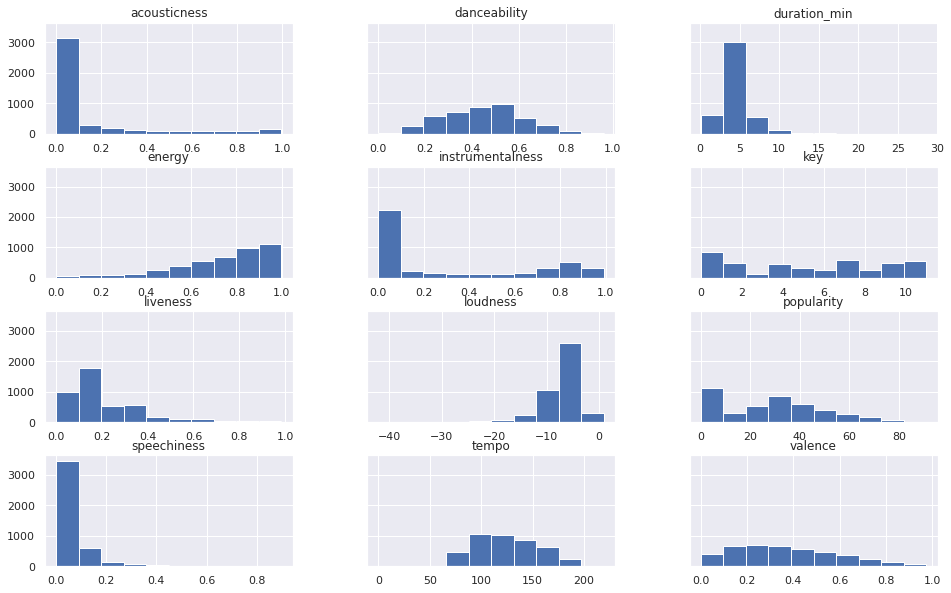

In [4]:
df[feat+['duration_min', 'popularity', 'key']].hist(sharey=True, figsize=(16, 10));

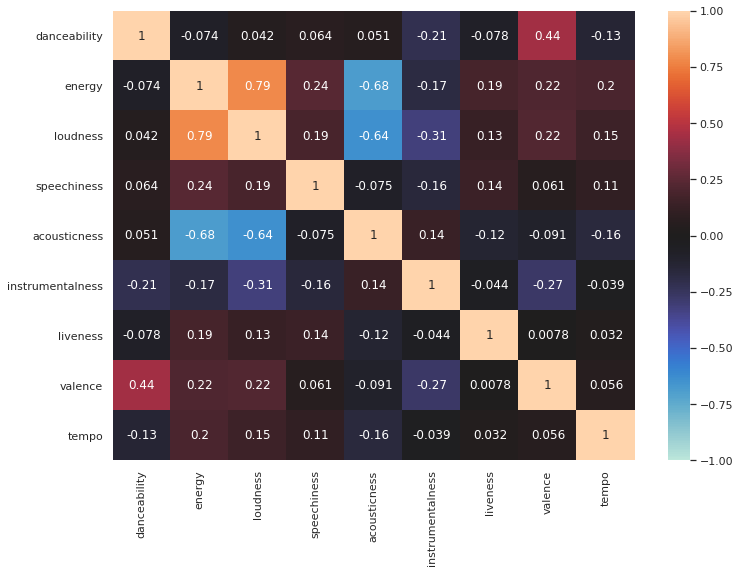

In [5]:
sns.heatmap(df[feat].corr(), annot=True, vmin=-1, vmax=1, center=0);

# Dimensionality Reduction and Clustering

## Dimensionality Reduction
There is 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

I use Mahalanobis distance metric because my data has:
- different variance and repartition shape
- low correlation (exept **loudness** and **energy**)

In [6]:
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from umap import UMAP

def mdl_fit_transform_precompute(metric, mdl, df=df[feat]):
    matrix_dist = squareform(pdist(df, metric=metric))
    proj = mdl.fit_transform(matrix_dist)
    plt.figure();
    sns.scatterplot(proj[:,0], proj[:,1]).set_title(metric);
    return proj

### PCA
I test with PCA, even thought from the correlation we can see that there is more than 2 components and as such PCA is not a solution

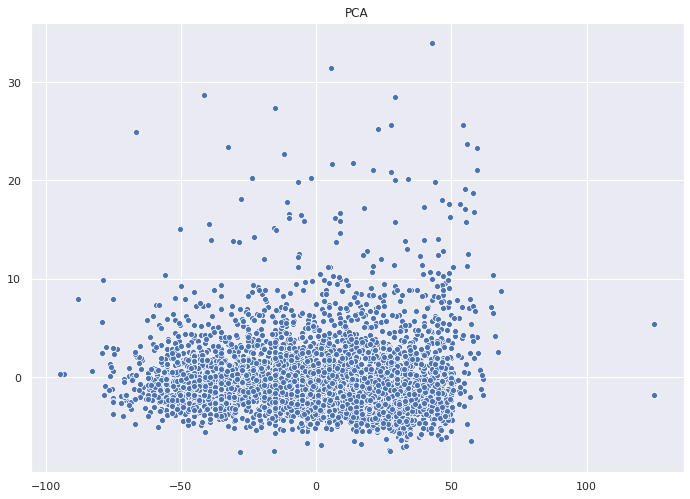

In [7]:
from sklearn.decomposition import PCA
mdl_pca = PCA(n_components=2, random_state=0)

proj = mdl_pca.fit_transform(df[feat])
plt.figure();
sns.scatterplot(proj[:,0], proj[:,1]).set_title('PCA');

### T-SNE

For T-SNE I applied 2 methods:
I tune the perplexity = n^(1/2) with n the number of observations (as KNN rule of thumbs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4316 samples in 0.029s...
[t-SNE] Computed neighbors for 4316 samples in 0.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4316
[t-SNE] Computed conditional probabilities for sample 2000 / 4316
[t-SNE] Computed conditional probabilities for sample 3000 / 4316
[t-SNE] Computed conditional probabilities for sample 4000 / 4316
[t-SNE] Computed conditional probabilities for sample 4316 / 4316
[t-SNE] Mean sigma: 0.485349
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.739334
[t-SNE] KL divergence after 5000 iterations: 1.596808


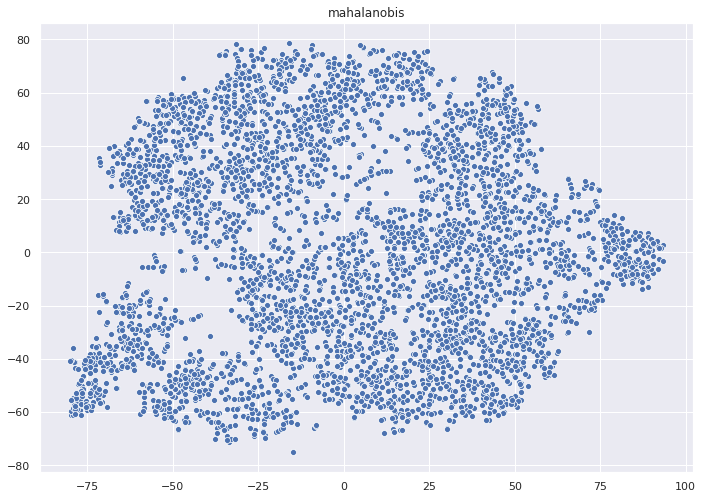

In [8]:
mdl_tsne = TSNE(
    perplexity=50,
    n_jobs=4,
    n_iter=5_000,
    n_iter_without_progress=500,
    verbose=1,
    metric='precomputed',
    random_state=0
)

proj_tsne = mdl_fit_transform_precompute('mahalanobis', mdl_tsne);

### UMAP
I think UMAP shoul be easier to tune (from previous experiment) and has more affinity for high dimension features.  
Moreover it is said to keep the global structures

UMAP(metric='precomputed', min_dist=0, n_epochs=1000, random_state=0, verbose=1)
Construct fuzzy simplicial set
Sat Jul  4 08:28:11 2020 Finding Nearest Neighbors
Sat Jul  4 08:28:15 2020 Finished Nearest Neighbor Search
Sat Jul  4 08:28:18 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Jul  4 08:28:48 2020 Finished embedding


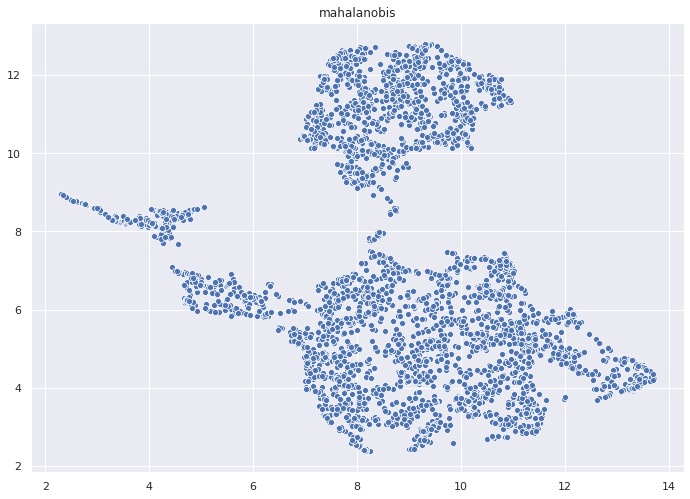

In [9]:
mdl_umap = UMAP(
    n_neighbors=15,
    min_dist=0,
    metric='precomputed',
    n_epochs=1000,
    verbose=1,
    random_state=0
)
proj_umap = mdl_fit_transform_precompute('mahalanobis', mdl_umap);

## Annex - influence of a grouping feature such as **key**:
Here is what happens if I add **key** as a feature and use UMAP the projection will be strongly biased in this direction (as the variance between observation is constant).
This is even more true with Mahalanobis distance metric. As such previous visualization as biased towards the key which could explain some strange clusters.

Here we can see that the fine-tuning of the clustering algorithms is important, and to visualize the clusters repartition in each dimension too.

UMAP(metric='mahalanobis', min_dist=0, n_epochs=1000, n_neighbors=30,
     random_state=0, verbose=1)
Construct fuzzy simplicial set
Sat Jul  4 08:28:49 2020 Finding Nearest Neighbors
Sat Jul  4 08:28:49 2020 Building RP forest with 8 trees
Sat Jul  4 08:28:51 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
Sat Jul  4 08:29:10 2020 Finished Nearest Neighbor Search
Sat Jul  4 08:29:11 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Jul  4 08:29:49 2020 Finished embedding


Text(0.5, 1.0, 'Mahanalobis with key included in features')

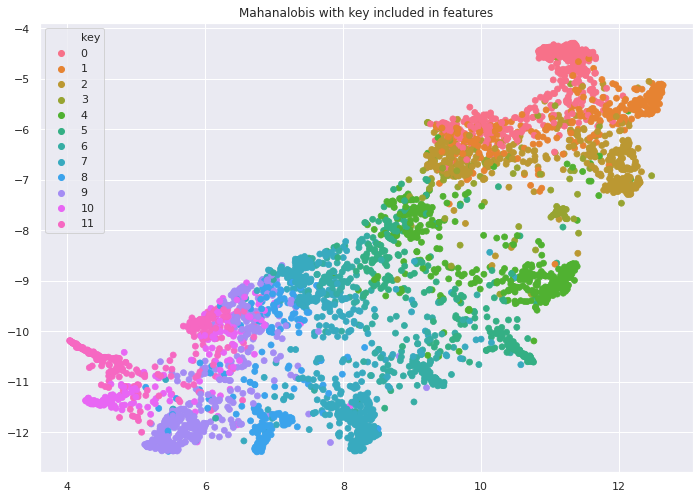

In [10]:
mdl_key = UMAP(
    n_neighbors=30,
    min_dist=0,
    metric='mahalanobis',
    n_epochs=1000,
    verbose=1,
    random_state=0
)

proj_key = mdl_key.fit_transform(df[[
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]])

plt.figure();
sns.scatterplot(
    proj_key[:,0], proj_key[:,1],
    hue=df['key'],
    legend='full',
    palette=sns.color_palette('husl', df['key'].max()+1),
    edgecolor=None
).set_title('Mahanalobis with key included in features')

## Clustering

### Annex - Supergenres from notebook 2 & **Key**
Let's see a bit where the supergenre calculated previously are in this projection

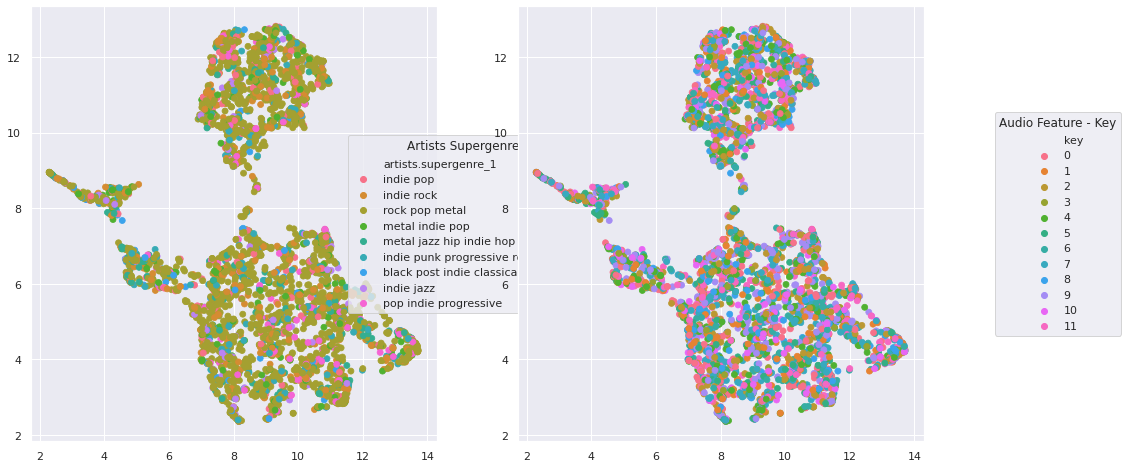

In [11]:
_, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(
    x=proj_umap[:,0],
    y=proj_umap[:,1],
    hue=df['artists.supergenre_1'],
    legend='full',
    palette='husl',
    edgecolor=None, 
    ax=axes[0]
).legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)\
.set_title('Artists Supergenres (1 only)')

sns.scatterplot(
    x=proj_umap[:,0],
    y=proj_umap[:,1],
    hue=df['key'],
    legend='full',
    palette=sns.color_palette('husl', df['key'].max()+1),
    edgecolor=None, 
    ax=axes[1]
).legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)\
.set_title('Audio Feature - Key')

This is expected, and even as intended, I am not focusing on a music genre, but on a music audio/sensation.
The clustering focus for example on:
* "sad" songs
* more vocal/lyrical songs
* energic, dancing songs

### HDBSCAN
I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
* min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
* min_samples is used to have a more or less conservative clustering (more outliers or less for each clusters)

In [13]:
from hdbscan import HDBSCAN

def cluster_analysis(clusters, proj):

    _, axes = plt.subplots(1, 2, figsize=(16,8))
    clusters.value_counts().plot(kind='barh', ax=axes[0], title='count of songs per clusters');
    sns.scatterplot(
        x=proj[:,0],
        y=proj[:,1],
        hue=clusters,
        legend='full',
        palette=sns.color_palette('husl', len(set(clusters))),
        edgecolor=None,
        ax=axes[1]
    ).legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1).set_title('Projection')

def cluster_analysis_detail(clusters, df=df):
    df['clusters'] = clusters

    # Draw a dot plot with "error" bars
    with sns.axes_style("whitegrid"):
        g = sns.PairGrid(df, x_vars=feat, y_vars='clusters', aspect=.25, height=12);
        g.map(sns.pointplot, join=False, palette="dark", orient='h');

        # Use semantically meaningful titles for the columns
        titles = [s.capitalize() for s in feat]

        for ax, title in zip(g.axes.flat, titles):
            # Set a different title for each axes
            ax.set(title=title)

            # Make the grid horizontal instead of vertical
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

        g.fig.subplots_adjust(wspace=.02, hspace=.02);

### HDBSCAN + T-SNE

100%|██████████| 90/90 [00:15<00:00,  5.87it/s]


Text(0.5, 1.0, '# clusters depending on hyperparameter')

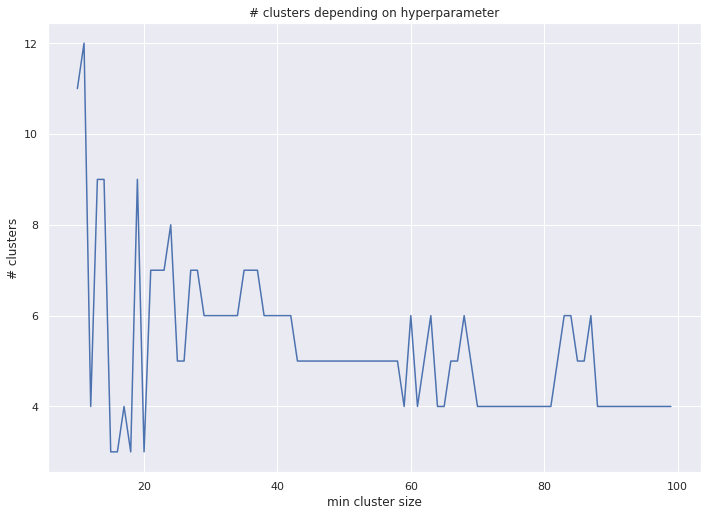

In [36]:
clusters_tsne_size = []

for min_cluster_size in tqdm(range(10, 100)):
    clusters_tsne = HDBSCAN(
        min_cluster_size=min_cluster_size,
        # cluster_selection_method='leaf'
    ).fit_predict(proj_tsne)
    clusters_tsne_size.append(len(set(clusters_tsne)))

plt.plot(list(range(10,100)), clusters_tsne_size)
plt.xlabel('min cluster size')
plt.ylabel('# clusters')
plt.title('# clusters depending on hyperparameter')

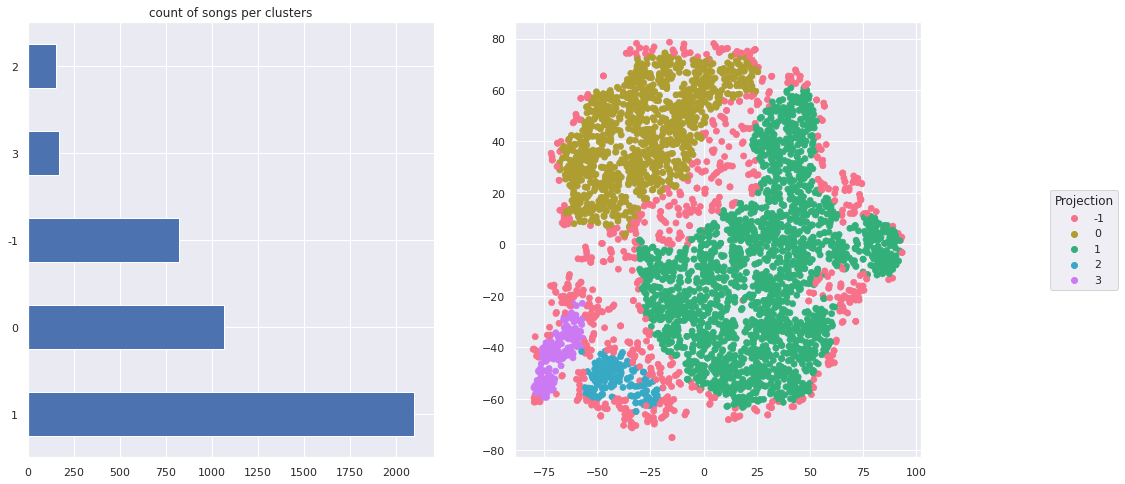

In [37]:
clusters_tsne = pd.Series(HDBSCAN(
        min_cluster_size=50,
    ).fit_predict(proj_tsne))
cluster_analysis(clusters_tsne, proj_tsne)

### HDBSCAN parameter tuning
**cluster_selection_method** is selected as **'leaf'** instead of **'eom'** because the clusters are too big (too global structure and not enough local) and need to be broken down.

100%|██████████| 90/90 [00:15<00:00,  5.69it/s]


Text(0.5, 1.0, '# clusters depending on hyperparameter')

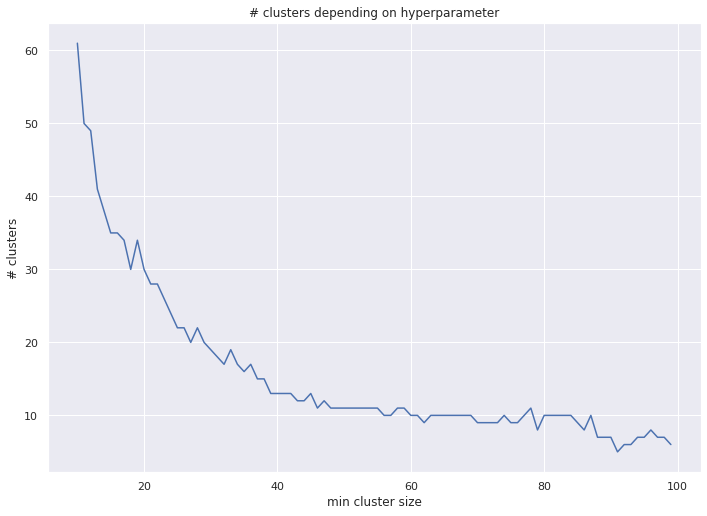

In [34]:
clusters_tsne_size = []

for min_cluster_size in tqdm(range(10, 100)):
    clusters_tsne = HDBSCAN(
        min_cluster_size=min_cluster_size,
        cluster_selection_method='leaf'
    ).fit_predict(proj_tsne)
    clusters_tsne_size.append(len(set(clusters_tsne)))

plt.plot(list(range(10,100)), clusters_tsne_size)
plt.xlabel('min cluster size')
plt.ylabel('# clusters')
plt.title('# clusters depending on hyperparameter')

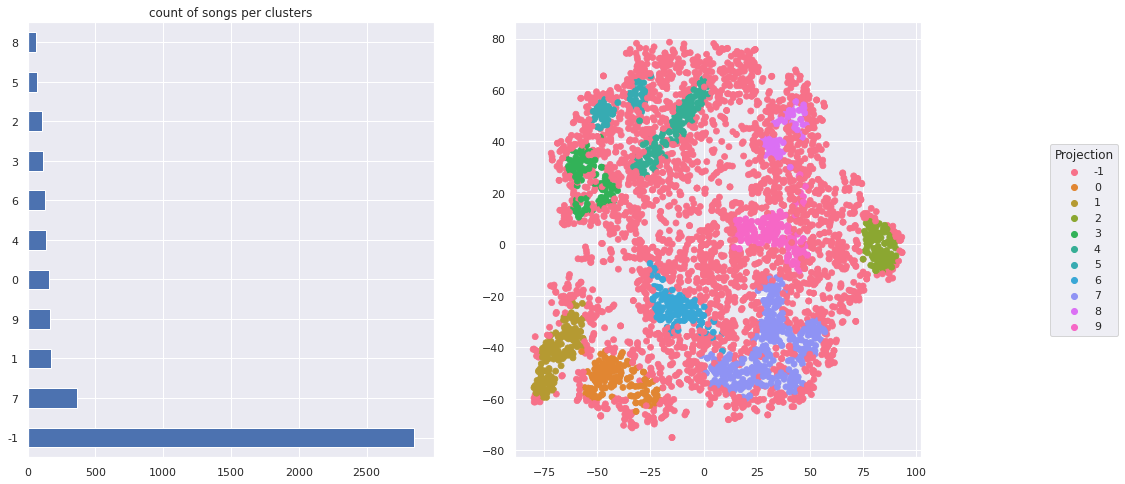

In [39]:
clusters_tsne = pd.Series(HDBSCAN(
        min_cluster_size=50,
        cluster_selection_method='leaf'
    ).fit_predict(proj_tsne))
cluster_analysis(clusters_tsne, proj_tsne)

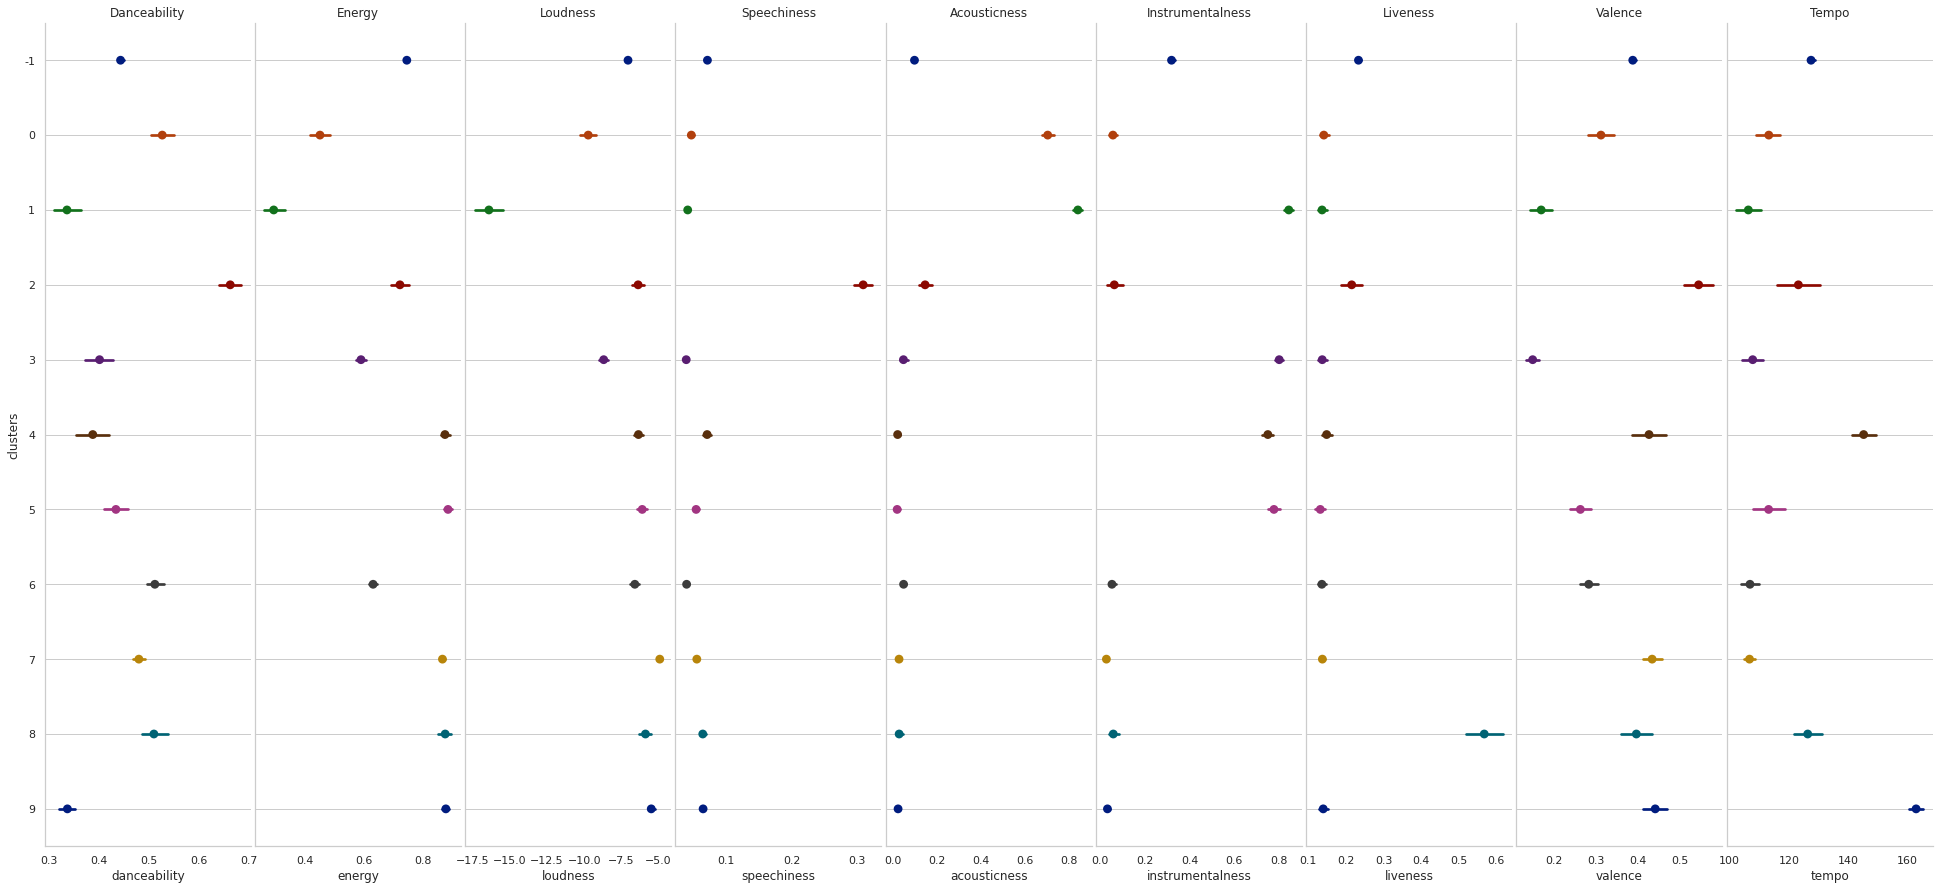

In [40]:
cluster_analysis_detail(clusters_tsne)

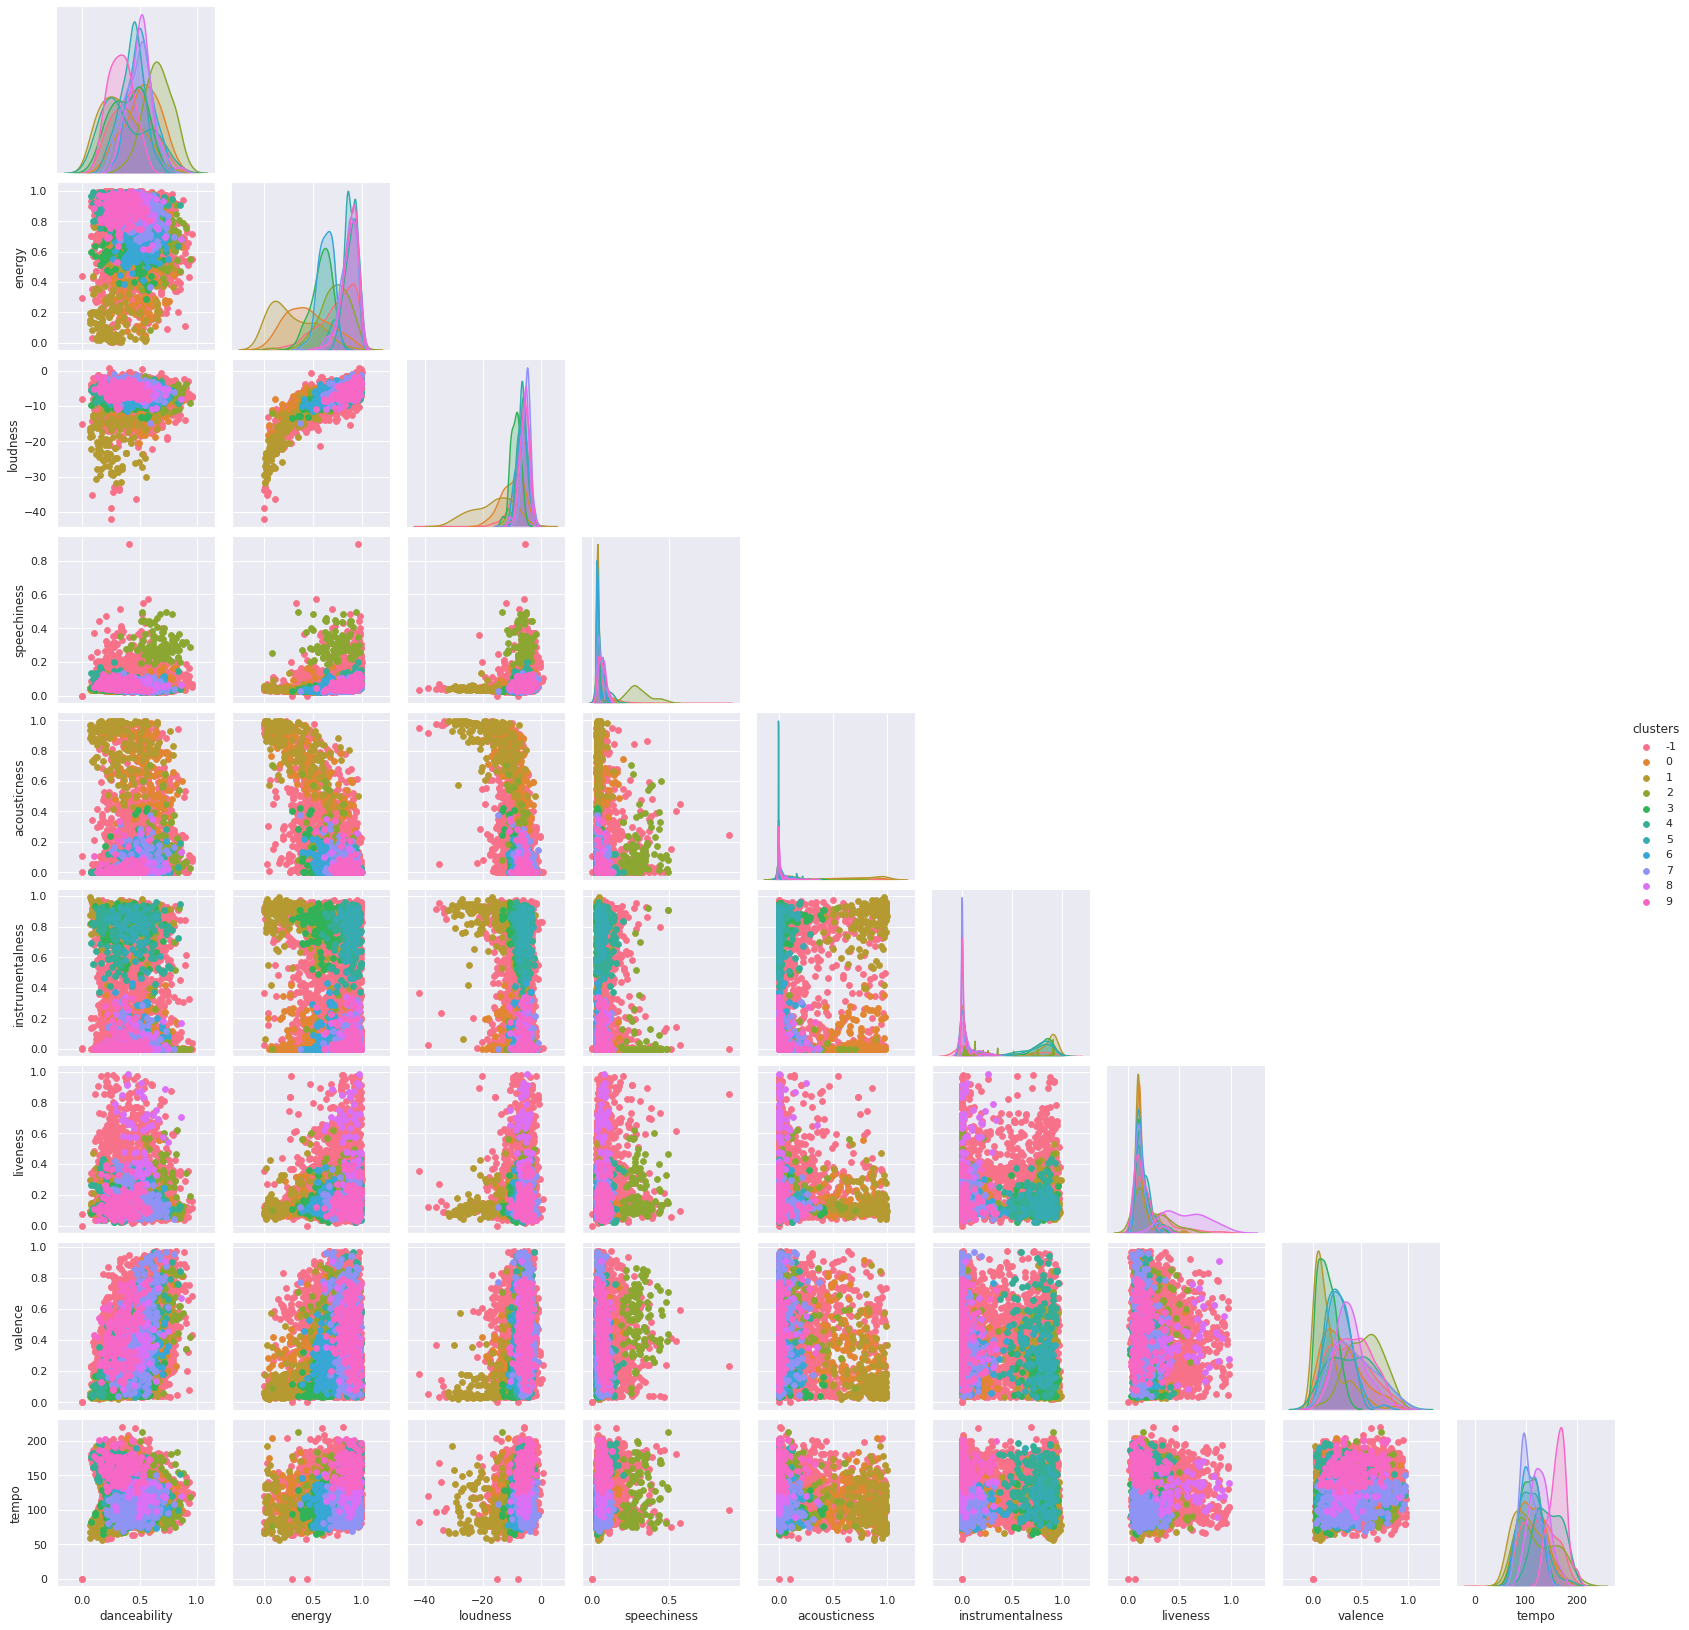

In [51]:
df['clusters'] = clusters_tsne

sns.pairplot(
    df[feat+['clusters']],
    hue='clusters',
    diag_kind='kde',
    corner=True,
    palette=sns.color_palette('husl', len(set(clusters_tsne))),
    plot_kws={'edgecolor':None,},
);

100%|██████████| 9/9 [00:00<00:00, 29.74it/s]


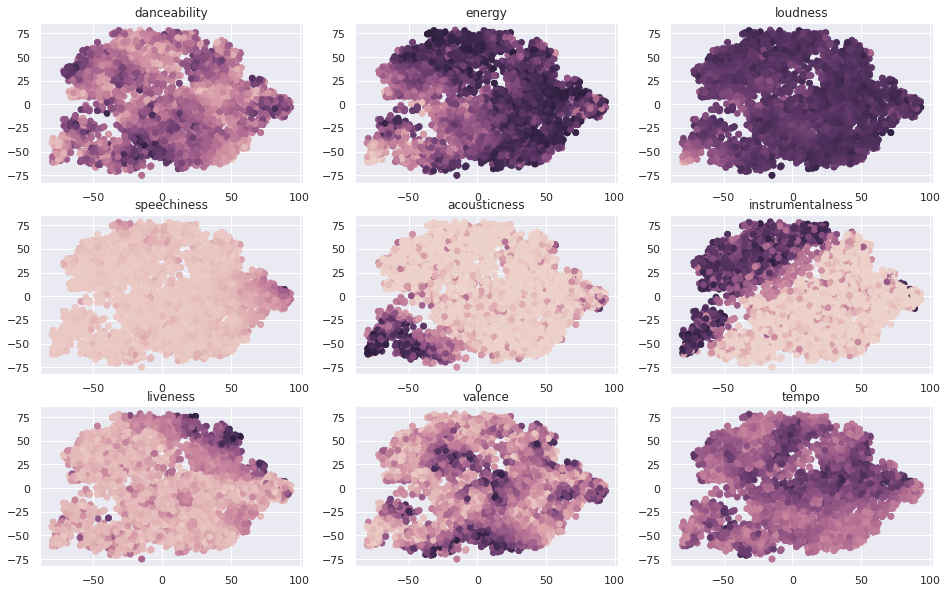

In [70]:
_, axes = plt.subplots(3, 3, figsize=(16,10))

for k, feat_col in enumerate(tqdm(feat)):
    sns.scatterplot(
        data=df,
        x=proj_tsne[:,0],
        y=proj_tsne[:,1],
        hue=df[feat_col],
        legend=None,
        edgecolor=None,
        ax=axes.flatten()[k]
    ).set_title(feat_col)

### HDBSCAN + UMAP

100%|██████████| 90/90 [00:13<00:00,  6.53it/s]


Text(0.5, 1.0, '# clusters depending on hyperparameter')

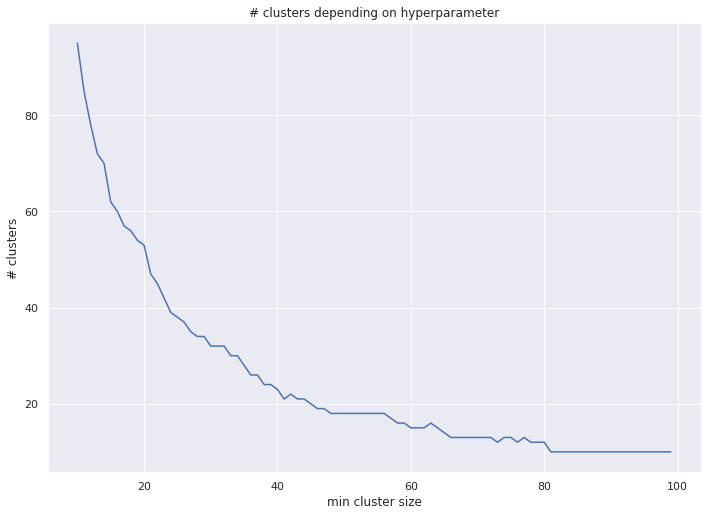

In [18]:
clusters_umap_size = []

for min_cluster_size in tqdm(range(10, 100)):
    clusters_umap = HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_method='leaf').fit_predict(proj_umap)
    clusters_umap_size.append(len(set(clusters_umap)))

plt.plot(list(range(10,100)), clusters_umap_size)
plt.xlabel('min cluster size')
plt.ylabel('# clusters')
plt.title('# clusters depending on hyperparameter')

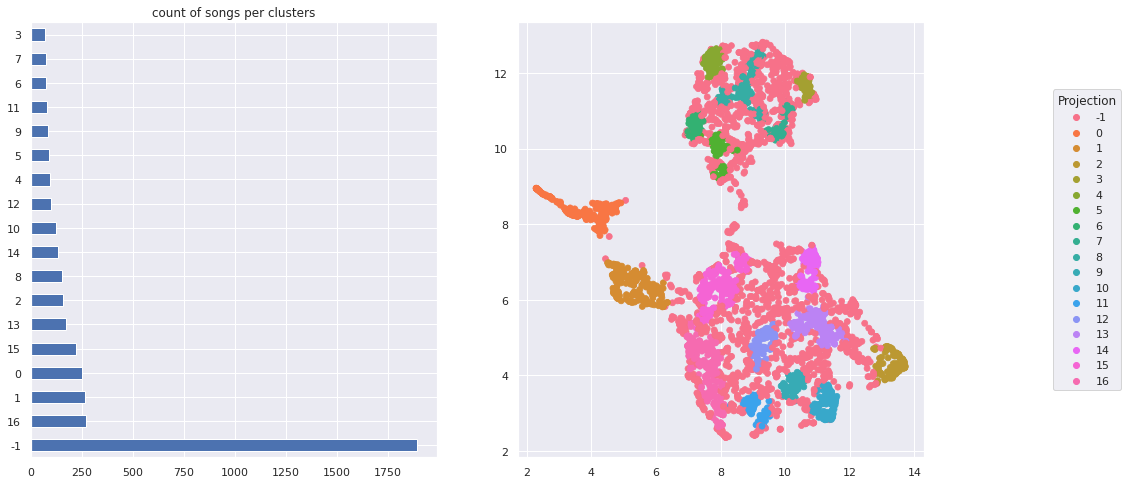

In [19]:
clusters_umap = pd.Series(HDBSCAN(min_cluster_size=50, cluster_selection_method='leaf').fit_predict(proj_umap))
cluster_analysis(clusters_umap, proj_umap)

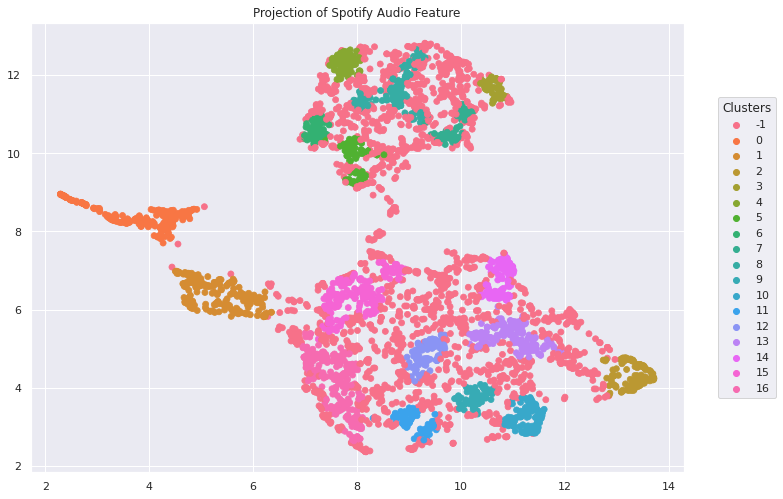

In [20]:
sns.scatterplot(
    x=proj_umap[:,0],
    y=proj_umap[:,1],
    hue=clusters_umap,
    legend='full',
    palette=sns.color_palette('husl', len(set(clusters_umap))),
    edgecolor=None,
).legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1).set_title('Clusters')

plt.title('Projection of Spotify Audio Feature');

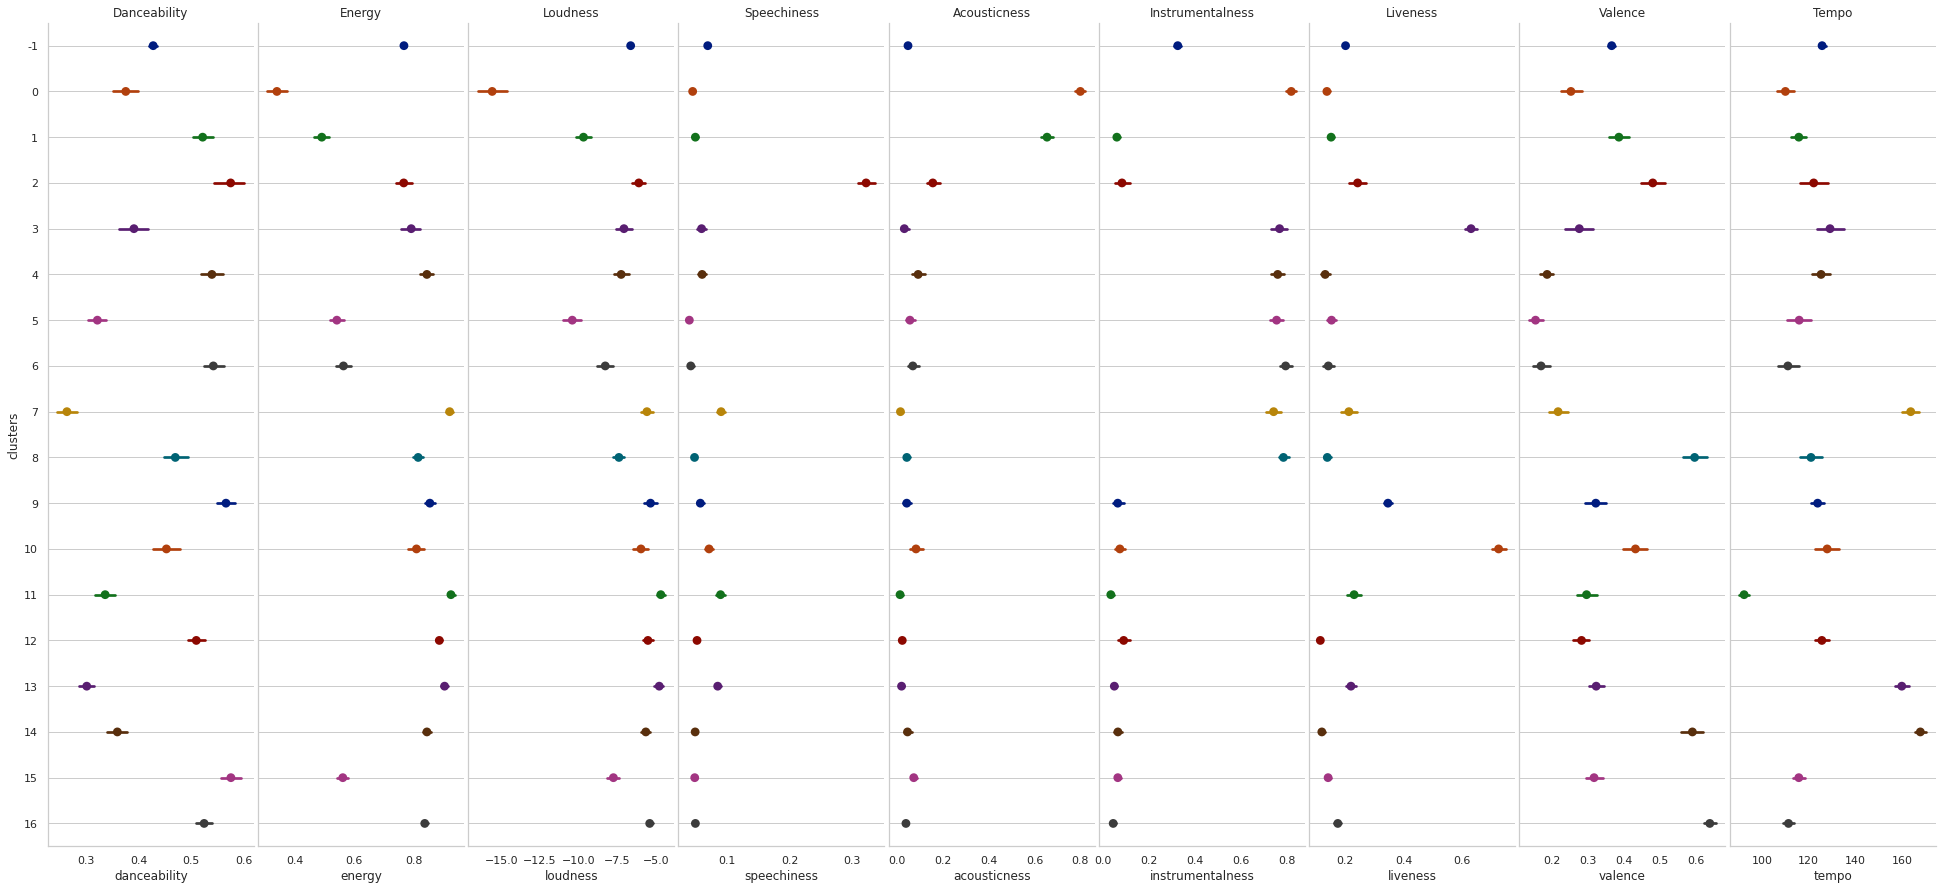

In [21]:
cluster_analysis_detail(clusters_umap)

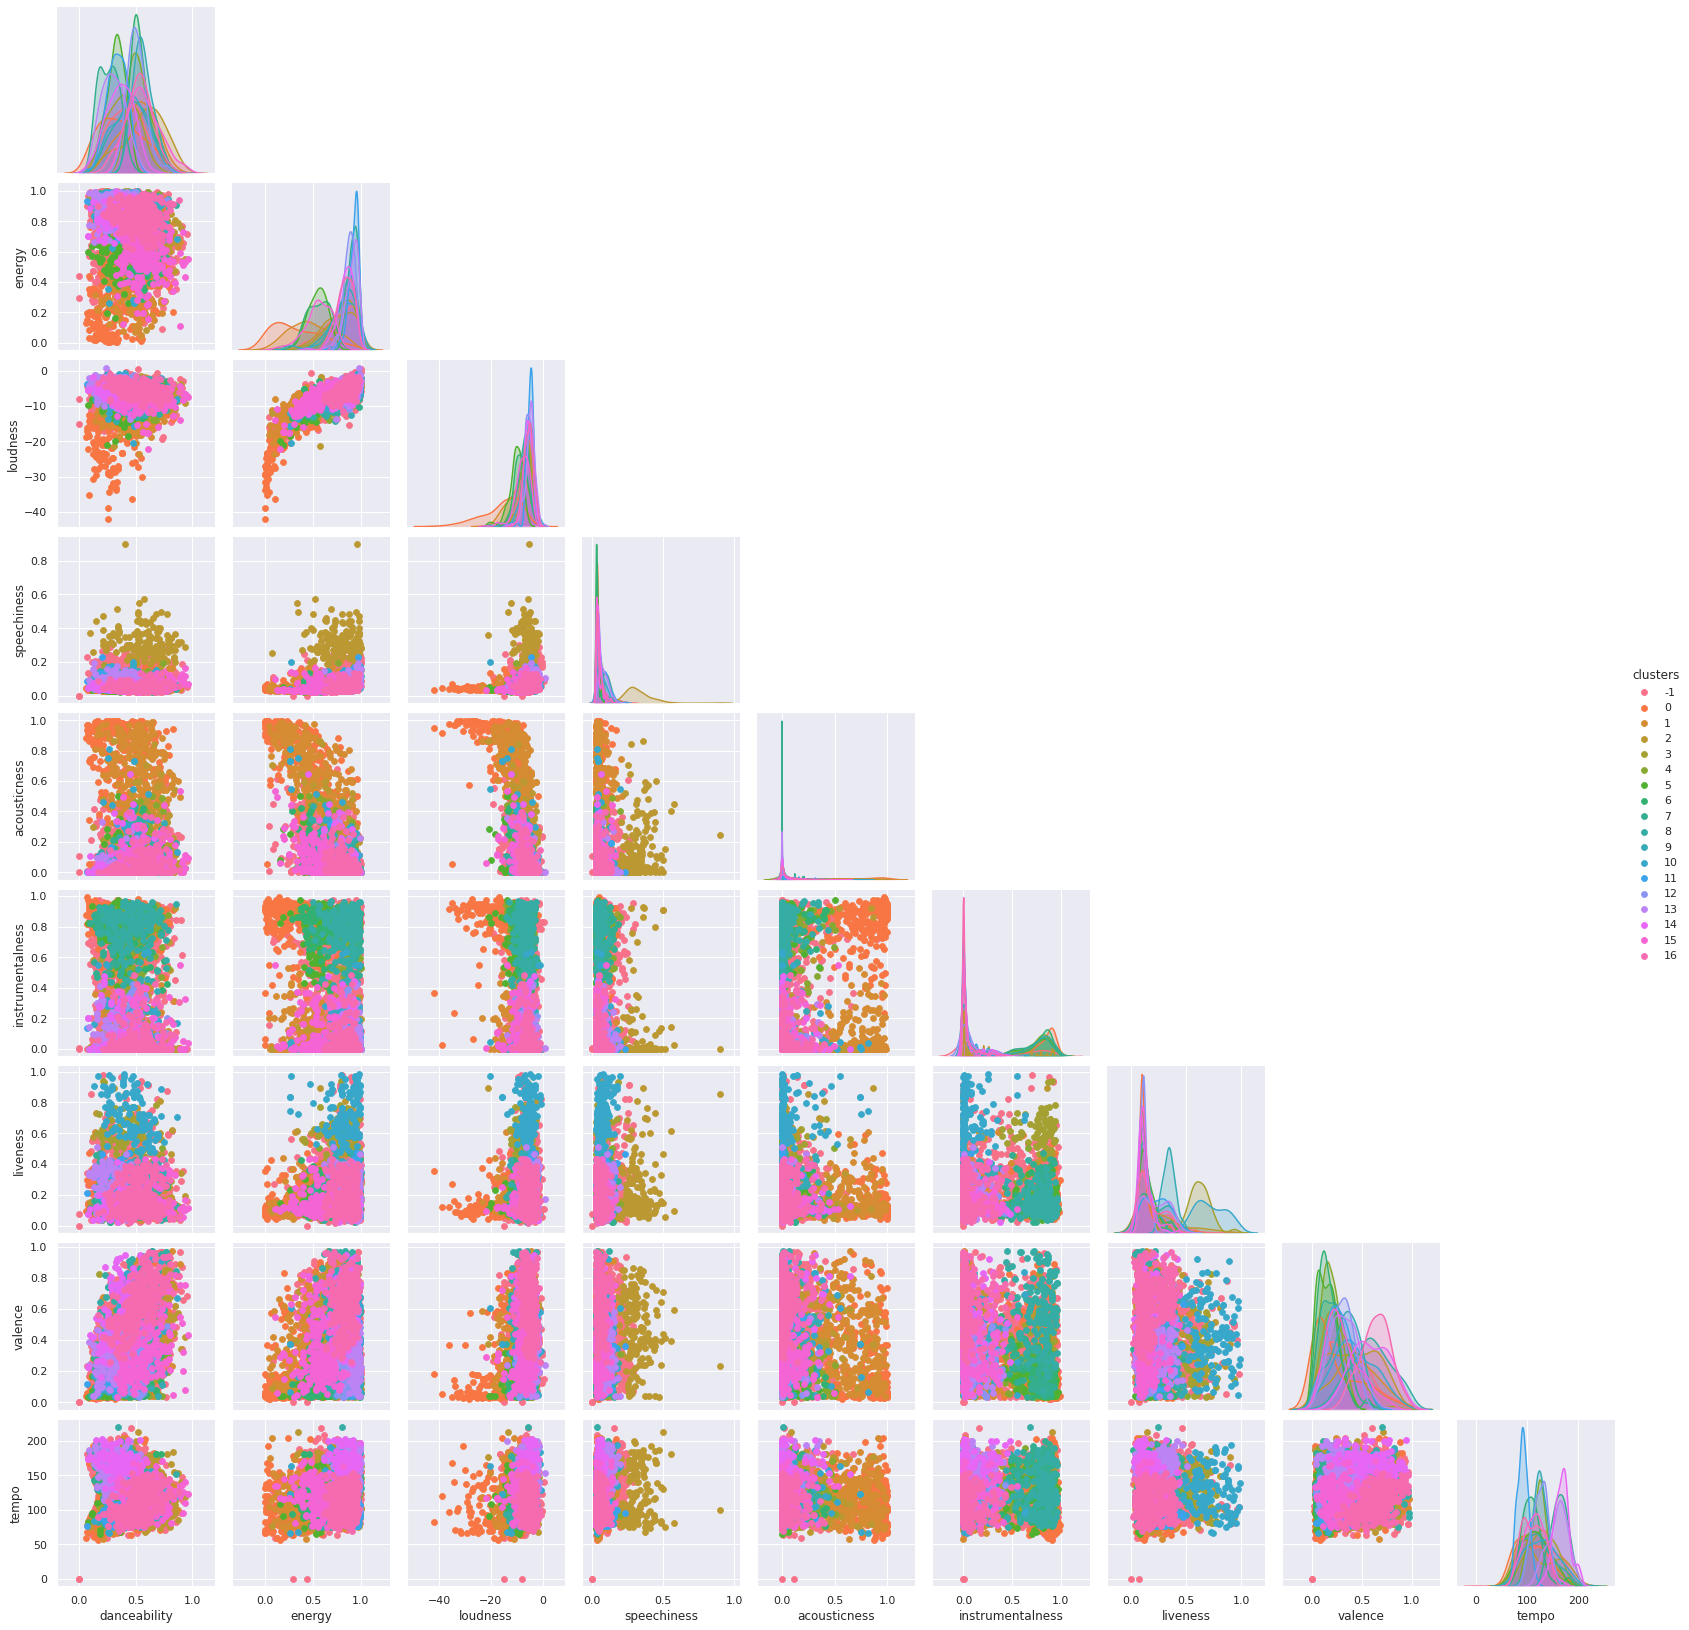

In [52]:
df['clusters'] = clusters_umap

sns.pairplot(
    df[feat+['clusters']],
    hue='clusters',
    diag_kind='kde',
    corner=True,
    palette=sns.color_palette('husl', len(set(clusters_umap))),
    plot_kws={'edgecolor':None,},
);

100%|██████████| 9/9 [00:00<00:00, 30.27it/s]


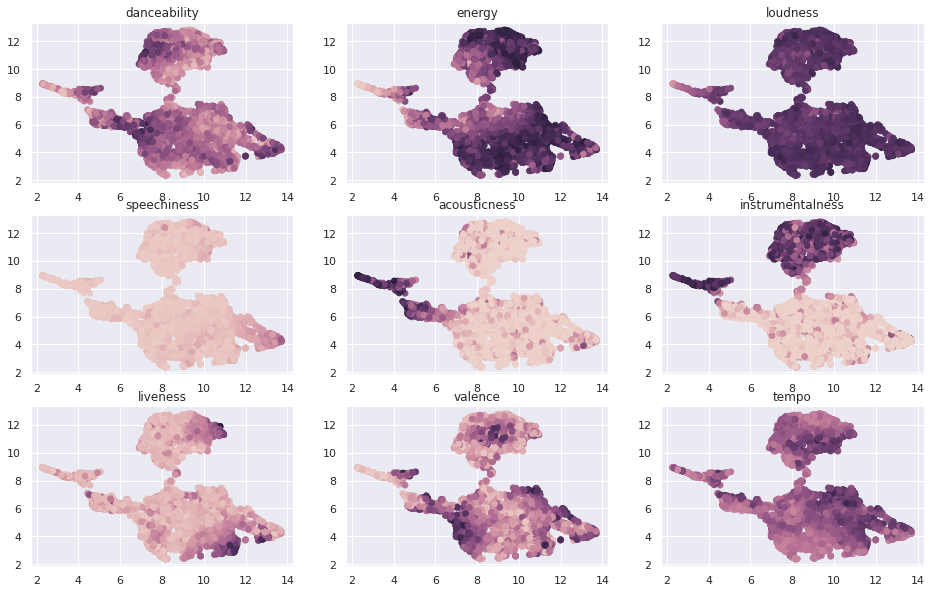

In [71]:
_, axes = plt.subplots(3, 3, figsize=(16,10))

for k, feat_col in enumerate(tqdm(feat)):
    sns.scatterplot(
        data=df,
        x=proj_umap[:,0],
        y=proj_umap[:,1],
        hue=df[feat_col],
        legend=None,
        edgecolor=None,
        ax=axes.flatten()[k]
    ).set_title(feat_col)

## Conclusion on Dimensionality Reduction and Clustering

We will chose UMAP + HDBSCAN as the result are satisfying. We have more separation of clusters in the following audio features:
- **liveness**
- **energy**
- **loudness**
- **tempo**

Moreover the shape of the projection has 3 clear groups which I would like to analyse more in detail. (kind of a global structure there)

# Visualization
Let's see if those clusters make sense by printing each 10 most popular songs  
An interactive plot with px would help see where the songs are in the projection and what they are

In [42]:
df['proj_x_tsne'] = proj_tsne[:,0]
df['proj_y_tsne'] = proj_tsne[:,1]
df['clusters_tsne'] = clusters_tsne
df['proj_x_umap'] = proj_umap[:,0]
df['proj_y_umap'] = proj_umap[:,1]
df['clusters_umap'] = clusters_umap

In [43]:
df['hover_text'] = df.apply(
    lambda x:
        f'<br>'+
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>' +
        f'Album: {x["album.name"]}<br>' +
        # f'Genres: {x["artists.genres"]}<br>'+
        # f'Super Genres: {x["artists.supergenres"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>',
    axis=1
)

df['fullname'] = df.apply(
    lambda x: f'{x["name"]}, {x["artists.name"]}<br>',
    axis=1
)

df['size'] = df['popularity'].apply(lambda x: np.log(x+1))

col = feat+[
    'clusters_tsne',
    'proj_x_tsne',
    'proj_y_tsne',
    'clusters_umap',
    'proj_x_umap',
    'proj_y_umap',
    'hover_text',
    'fullname',
    'size',
    'preview_url',
    'popularity'
]

# My most popular songs in a 2D plot

After I projected my 4000+ liked songs in my Spotify playlist, I projected it with UMAP and clustered with HDBSCAN.
Those are the top3 most popular songs in each of the clusters.

Below is a plot done with Plotly, where I embedded a link to a song preview file.

As such you can as well hover over the points to know which song it is or click on it to listen to it.

In [47]:
# count of most popular songs to analyse
top_n = 3

## T-SNE

In [48]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

df_top = df[col].groupby('clusters_tsne').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(top_n)
)

fig = px.scatter(
    df_top,
    x='proj_x_tsne',
    y='proj_y_tsne',
    hover_name='fullname',
    hover_data=['hover_text'],
    text=df_top['preview_url'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color=df_top['clusters_tsne'].astype(str),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title=f'my top {top_n} songs per T-SNE cluster'
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)

UMAP

In [50]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

df_top = df[col].groupby('clusters_umap').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(top_n)
)

fig = px.scatter(
    df_top,
    x='proj_x_umap',
    y='proj_y_umap',
    hover_name='fullname',
    hover_data=['hover_text'],
    text=df_top['preview_url'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color=df_top['clusters_umap'].astype(str),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title=f'my top {top_n} songs per UMAP cluster'
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)

### Conclusion

Which one of the 2 is best is difficult to say.

We have a leaf shaping in T-SNE with many "correct" clusters. But we lack a more global localization (all metal songs together for example).
This global localization is found with UMAP, but with some outliers inside it. Moreover in the UMAP we can multilple times that:
* some artists songs are heavily into 1 cluster (like Nirvana) which is expected
* even though we have many clusters (<10), they make sense for most
* we can see that the representation would continue to grow in islands (rap, metal, electro)

I would say in layman terms, it seems easier to navigate in the UMAP projection than the T-SNE (That's subjective).